<a href="https://colab.research.google.com/github/cest0/PPConstrFcst/blob/master/Proto_Hydro_PP_constraints_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydro power plant constraints forecast

### Import libraries

In [2]:
!pip install treeinterpreter

In [0]:
import math
import pandas as pd
import numpy as np
import array as arr
from pandas import ExcelWriter
from pandas import ExcelFile
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statistics 

### Read source file into data frame and display columns

In [62]:
from google.colab import files
uploaded = files.upload()

Saving Offer_Data.xlsm to Offer_Data (1).xlsm


In [78]:
df = pd.read_excel('Offer_Data.xlsm', sheet_name='Data')
display(df.columns)

Index([               'Variante 1',                           1,
                                 2,                           3,
                                 4,                           5,
                                 6,                           7,
                                 8,                       '1.1',
                             '2.1',                       '3.1',
                             '4.1',                       '5.1',
                             '6.1',                       '7.1',
                             '8.1',               'Unnamed: 17',
                      'Variante 2',                       '1.2',
                             '2.2',                       '3.2',
                             '4.2',                       '5.2',
                             '6.2',                       '7.2',
                             '8.2',                       '1.3',
                             '2.3',                       '3.3',
                         

### Check first few lines of imported file

In [79]:
df.head()

Variante 1     1  ...  Availability plant 3 [%]  Availability plant 4 [%]
0 2014-04-01  73.8  ...                  1.000000                       1.0
1 2014-04-02  73.8  ...                  1.000000                       1.0
2 2014-04-03  73.8  ...                  0.291667                       1.0
3 2014-04-04  73.8  ...                  0.250000                       1.0
4 2014-04-05  72.6  ...                  1.000000                       1.0

[5 rows x 92 columns]

In [80]:
# display info about our dataframe, i.e. features types, labels, number of values including NaN indication
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 92 columns):
Variante 1                   1736 non-null datetime64[ns]
1                            1731 non-null float64
2                            1731 non-null float64
3                            1731 non-null float64
4                            1731 non-null float64
5                            1731 non-null float64
6                            1731 non-null float64
7                            1731 non-null float64
8                            1183 non-null float64
1.1                          1731 non-null float64
2.1                          1731 non-null float64
3.1                          1731 non-null float64
4.1                          1731 non-null float64
5.1                          1731 non-null float64
6.1                          1731 non-null float64
7.1                          1731 non-null float64
8.1                          1188 non-null float64
Unnamed: 17        

In [0]:
# Rename first column to "date"
df.rename(columns={ df.columns[0]: "Date"}, inplace=True)
# Force index to be date (as provided in the first column)
df.index = df['Date']

In [0]:
# Heading for "Min prod" change to "Min prod date" and next column named "Min prod" (since heading missing)
indexMP =  np.where(df.columns =="Min prod")[0][0]
df.rename(columns={ df.columns[indexMP]: "Min prod date"}, inplace=True)
df.rename(columns={ df.columns[indexMP+1]: "Min prod"}, inplace=True)

In [83]:
# Extract columns names to be renamed, in order to make them more explicit
col_names = []
for col_name in df.columns:
    col_names.append(col_name)

# loop through all column names, to check which ones need to be made more explicit, i.e. in a V1P2 format 
# where 1 is the variant number and 2 identifies the 2nd value for Power ("P")
for i in range(len(col_names)):
    col_name = col_names[i]
    # if column name if numerical (f. ex 3.4), it is an automatic name assigned by the panda library
    # we give it a more explicit name, in the for Var2H3 (variant number 2, Hour value, 3rd value)
    if re.match( r"^([0-9]?).([0-9]?)$", str(col_name), re.M):
        # check actual format: is there a decimal point?
        if re.match( r"^([0-9]?)$", str(col_name), re.M):
            # no decimal point -> we add one for consistency
            col_name = str(col_name)+".0"
        # name is in format: n.m, n= value index, m = variant nr + indication nb hour or power value
        (n,m) = col_name.split(".")
        # if n is even, this is a power value, if odd, a number of hours
        # m is the variant number (option)
        New_Col_Name = "Var" + str((int(m)+2) // 2) 
        if (int(m) % 2) == 0:
            New_Col_Name += "P"+str(n)
        else:
            New_Col_Name += "H"+str(n) 
        #print(New_Col_Name)
        col_names[i] = New_Col_Name
        
df.columns = col_names

# debug       
display(df.columns)


Index(['Date', 'Var1P1', 'Var1P2', 'Var1P3', 'Var1P4', 'Var1P5', 'Var1P6',
       'Var1P7', 'Var1P8', 'Var1H1', 'Var1H2', 'Var1H3', 'Var1H4', 'Var1H5',
       'Var1H6', 'Var1H7', 'Var1H8', 'Unnamed: 17', 'Variante 2', 'Var2P1',
       'Var2P2', 'Var2P3', 'Var2P4', 'Var2P5', 'Var2P6', 'Var2P7', 'Var2P8',
       'Var2H1', 'Var2H2', 'Var2H3', 'Var2H4', 'Var2H5', 'Var2H6', 'Var2H7',
       'Var2H8', 'Unnamed: 35', 'Variante 3', 'Var3P1', 'Var3P2', 'Var3P3',
       'Var3P4', 'Var3P5', 'Var3P6', 'Var3P7', 'Var3P8', 'Var3H1', 'Var3H2',
       'Var3H3', 'Var3H4', 'Var3H5', 'Var3H6', 'Var3H7', 'Var3H8',
       'Unnamed: 53', 'Variante 4', 'Var4P1', 'Var4P2', 'Var4P3', 'Var4P4',
       'Var4P5', 'Var4P6', 'Var4P7', 'Var4P8', 'Var4H1', 'Var4H2', 'Var4H3',
       'Var4H4', 'Var4H5', 'Var4H6', 'Var4H7', 'Var4H8', 'Unnamed: 71',
       'Min prod date', 'Min prod', 'Unnamed: 74', 'Inflow lake 1 [m3]',
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]',
       'Unnamed: 79', 'Vol 

### Removal of empty columns

In [84]:
# Remove columns that are unnamed (as they are empty)
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
# debug       
print("Column headings:")
display(df.columns)

Column headings:


Index(['Date', 'Var1P1', 'Var1P2', 'Var1P3', 'Var1P4', 'Var1P5', 'Var1P6',
       'Var1P7', 'Var1P8', 'Var1H1', 'Var1H2', 'Var1H3', 'Var1H4', 'Var1H5',
       'Var1H6', 'Var1H7', 'Var1H8', 'Variante 2', 'Var2P1', 'Var2P2',
       'Var2P3', 'Var2P4', 'Var2P5', 'Var2P6', 'Var2P7', 'Var2P8', 'Var2H1',
       'Var2H2', 'Var2H3', 'Var2H4', 'Var2H5', 'Var2H6', 'Var2H7', 'Var2H8',
       'Variante 3', 'Var3P1', 'Var3P2', 'Var3P3', 'Var3P4', 'Var3P5',
       'Var3P6', 'Var3P7', 'Var3P8', 'Var3H1', 'Var3H2', 'Var3H3', 'Var3H4',
       'Var3H5', 'Var3H6', 'Var3H7', 'Var3H8', 'Variante 4', 'Var4P1',
       'Var4P2', 'Var4P3', 'Var4P4', 'Var4P5', 'Var4P6', 'Var4P7', 'Var4P8',
       'Var4H1', 'Var4H2', 'Var4H3', 'Var4H4', 'Var4H5', 'Var4H6', 'Var4H7',
       'Var4H8', 'Min prod date', 'Min prod', 'Inflow lake 1 [m3]',
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]',
       'Vol lake 1 [1000m3]', 'Vol lake 1 [%]', 'Max Zer [1000m3]',
       'Availability plant 1 [MW]', 'Avai

### Removal of redundant columns

### Missing values management

In [0]:
df.drop(labels=['Availability plant 1 [MW]', 'Availability plant 2 [MW]',  \
                'Availability plant 3 [MW]','Availability plant 4 [MW]',   \
                'Min prod date', 'Variante 2','Variante 3','Variante 4',   \
                'Vol lake 1 [1000m3]'],  \
        axis = 1, inplace = True)

In [0]:
# fill up missing 8th value with 0s, for all variants (power nd number of hours)
for iVar in range(1,4+1):
    HourIndex = "Var"+str(iVar)+"H8"
    PwrIndex = "Var"+str(iVar)+"P8"
    # for column 8, replace missing values with 0
    df[HourIndex].fillna(0, inplace=True)
    df[PwrIndex].fillna(0, inplace=True)

In [87]:
# Check missing values
null_columns=df.columns[df.isnull().any()]
df[df.isnull().any(axis=1)][null_columns].head(50)

Var1P1  Var1P2  Var1P3  Var1P4  ...  Var4H5  Var4H6  Var4H7  Min prod
Date                                        ...                                  
2015-10-08    69.0    66.0     0.0     0.0  ...     0.0     0.0     0.0     270.0
2015-12-31     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN       NaN
2016-11-01     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN       NaN
2016-11-02     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN       NaN
2016-11-03     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN       NaN
2016-12-26     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN       NaN

[6 rows x 57 columns]

In [0]:
#Fill up missing values by interpolation
df.interpolate(method='linear',limit_direction ='forward',inplace=True)

### Feature engineering

In [0]:
# Add calculated columns for gloabl values, i.e. total energy per variant, average energy per offer
# compute total energy for variante 1 to 4, as scalar product: power * nb of hours

NbVar = pd.Series(np.zeros(len(df)), index = df.index) # initialize to 0

#Loop over 4 variants
for iVar in range(1,4+1):
    PowerVar = pd.Series(np.zeros(len(df))) # initialize to 0
    PowerVar.index = df.index
    VarCount = 0 # count the number of variants defined on a given day
    # loop over the 8 pairs : power, nb of hours
    for i in range(1, 8+1):
        HourIndex = "Var"+str(iVar)+"H"+str(i)
        PwrIndex = "Var"+str(iVar)+"P"+str(i)
        PowerVar += df[HourIndex]*df[PwrIndex]
    # Add column to dataframe
    New_Col_Name = "EnergyVar"+str(iVar)
    df.insert(len(df.columns),New_Col_Name, PowerVar)
    
# Compute number of defined variants
NbVar = df["EnergyVar1"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar2"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar3"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar4"].map(lambda x: 1 if x > 0 else 0 ) 

# Add column that counts number of defined variants       
df.insert(len(df.columns),"NbVar", NbVar)

In [90]:
# debug - fix
#df.drop("NbVar", axis=1, inplace=True)
#df.drop("EnergyVar1", axis=1, inplace=True)
#df.drop("EnergyVar2", axis=1, inplace=True)
#df.drop("EnergyVar3", axis=1, inplace=True)
#df.drop("EnergyVar4", axis=1, inplace=True)
df.head()

Date  Var1P1  Var1P2  ...  EnergyVar3  EnergyVar4  NbVar
Date                                   ...                               
2014-04-01 2014-04-01    73.8    66.0  ...       961.2         0.0      2
2014-04-02 2014-04-02    73.8    66.0  ...       961.2         0.0      2
2014-04-03 2014-04-03    73.8    66.0  ...       961.2         0.0      2
2014-04-04 2014-04-04    73.8    66.0  ...       961.2         0.0      2
2014-04-05 2014-04-05    72.6    66.0  ...       961.2         0.0      2

[5 rows x 81 columns]

In [0]:
# Calculating the single variante according to defined variants by priority order (1,2,3,4)

VariantePrioOrder = df.apply(
    lambda row: row['EnergyVar1'] if row['EnergyVar1']>0 else \
      ( row['EnergyVar2'] if row['EnergyVar2']>0 else \
       ( row['EnergyVar3'] if row['EnergyVar3']>0 else \
        ( row['EnergyVar4']))) 
       ,
    axis=1
)
# Add column that counts number of defined variants       
df.insert(len(df.columns),"Variante Prio", VariantePrioOrder)


In [0]:
# Add feature indicating if the date is a weekend day or a weekday
#df['Weekend'] = (df['Variante 1'].weekday() == 5 | df['Variante 1'].weekday()== 6)
Weekend = df['Date'].map(lambda x: x.weekday()==5 or x.weekday()==6 ) 
# Add column that indicates if day is weekend (True in this case)   
df.insert(len(df.columns),"Weekend", Weekend)

In [93]:
# display basic stasticss of data frame
display(round(df.describe()),2)

Var1P1  Var1P2  Var1P3  ...  EnergyVar4   NbVar  Variante Prio
count  1736.0  1736.0  1736.0  ...      1736.0  1736.0         1736.0
mean     54.0    41.0    22.0  ...        37.0     2.0          723.0
std      24.0    23.0    22.0  ...       119.0     1.0          361.0
min       0.0     0.0     0.0  ...         0.0     0.0            0.0
25%      50.0    27.0     0.0  ...         0.0     1.0          497.0
50%      65.0    47.0    18.0  ...         0.0     2.0          771.0
75%      69.0    60.0    44.0  ...         0.0     2.0          942.0
max      77.0    74.0    84.0  ...       851.0     4.0         1546.0

[8 rows x 81 columns]

2

### Visual data analysis

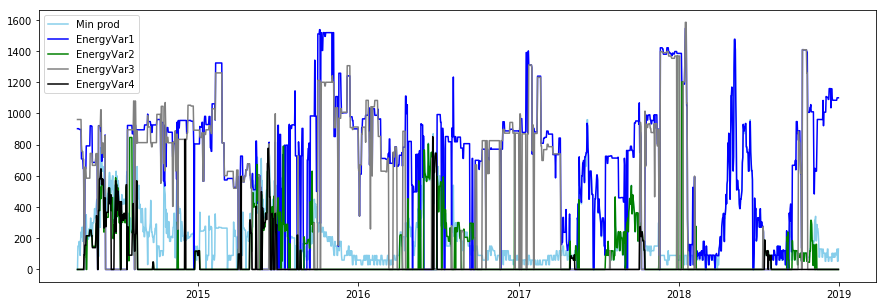

In [94]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
  
# Plot target feature time series all together
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size  
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('EnergyVar1', data=df, color='blue')
plt.plot('EnergyVar2', data=df, color='green')
plt.plot('EnergyVar3', data=df, color='grey')
plt.plot('EnergyVar4', data=df, color='black')
plt.legend()


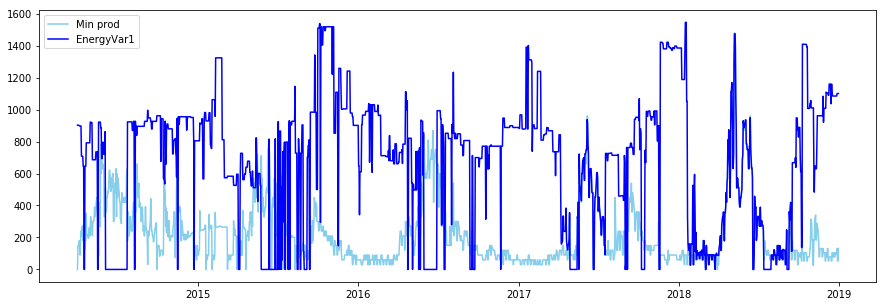

In [95]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('EnergyVar1', data=df, color='blue')
plt.legend()

In [0]:
# check max of all variants
df['MaxVariants'] = df[['EnergyVar1','EnergyVar2','EnergyVar3','EnergyVar4']].max(axis=1)

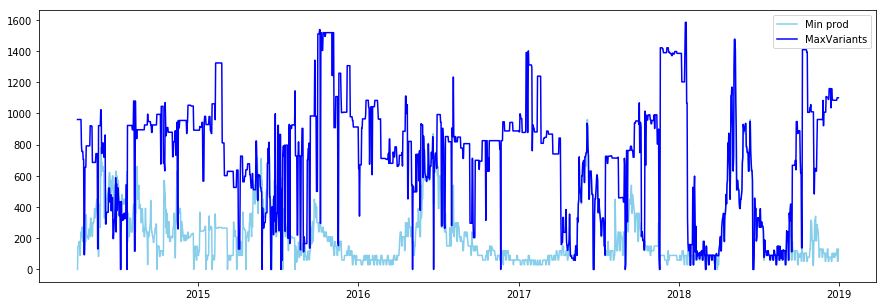

In [97]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('MaxVariants', data=df, color='blue')
plt.legend()

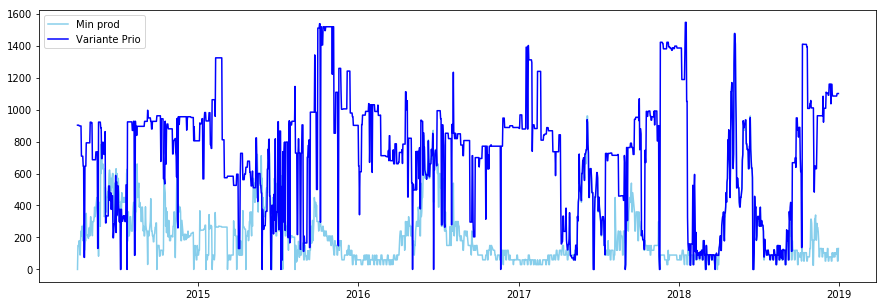

In [98]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('Variante Prio', data=df, color='blue')
plt.legend()

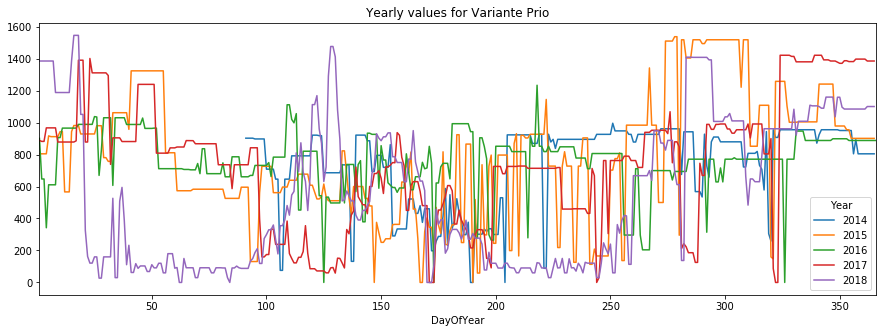

In [100]:
# all value plotted on one year
VariantPrio = pd.DataFrame(df.loc[:, ['Date','Variante Prio']])
VariantPrio.index = VariantPrio['Date']

# Add the year and day of years features, then pivot to have one column of data per year (ronw = day of year)
VariantPrio["Year"] = VariantPrio.index.year
VariantPrio["DayOfYear"] = VariantPrio.index.dayofyear
 
YearVariantPrio = VariantPrio.pivot(index='DayOfYear', columns='Year', values='Variante Prio')

YearVariantPrio.plot(title="Yearly values for Variante Prio")

### Autocorellation function plot (ACF)
Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

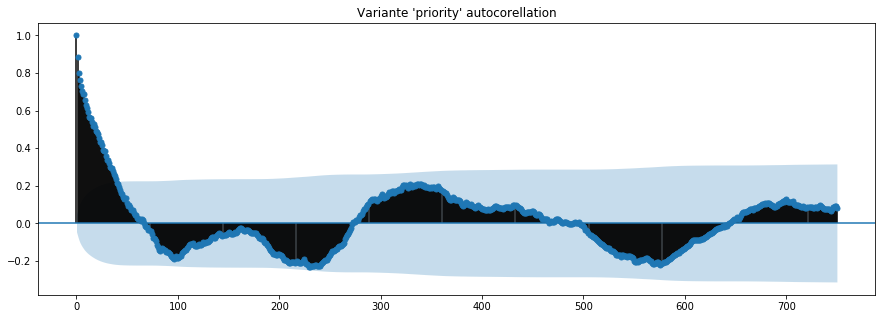

In [29]:
# plot correlogram
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Variante Prio'], lags=750, title ="Variante 'priority' autocorellation")
pyplot.show()

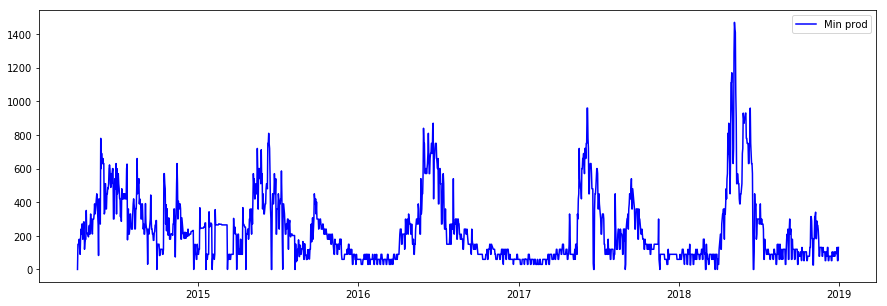

In [30]:
# Plot minimum production
plt.plot('Min prod', data=df, color='blue')
plt.legend()

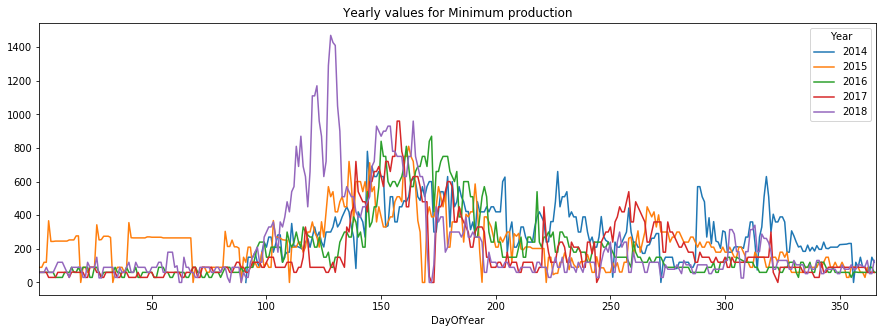

In [103]:
# all value plotted on one year
MindProd = pd.DataFrame(df.loc[:, ['Date','Min prod']])
MindProd.index = MindProd['Date']

# Add the year and day of years features, then pivot to have one column of data per year (ronw = day of year)
MindProd["Year"] = MindProd.index.year
MindProd["DayOfYear"] = MindProd.index.dayofyear
 
YearMindProd = MindProd.pivot(index='DayOfYear', columns='Year', values='Min prod')

YearMindProd.plot(title="Yearly values for Minimum production")

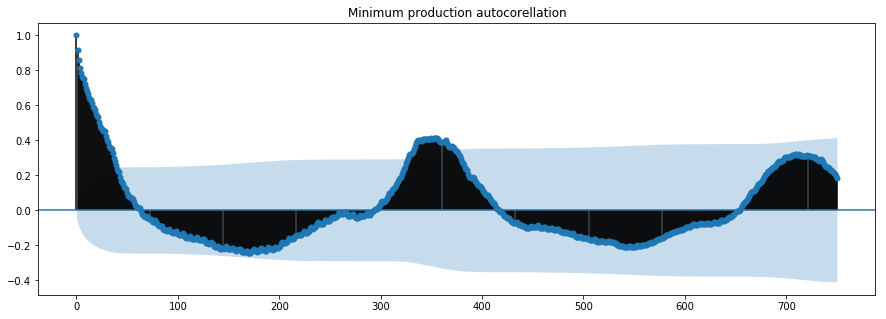

In [102]:
# plot correlogram
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Min prod'], lags=750, title ="Minimum production autocorellation")
pyplot.show()


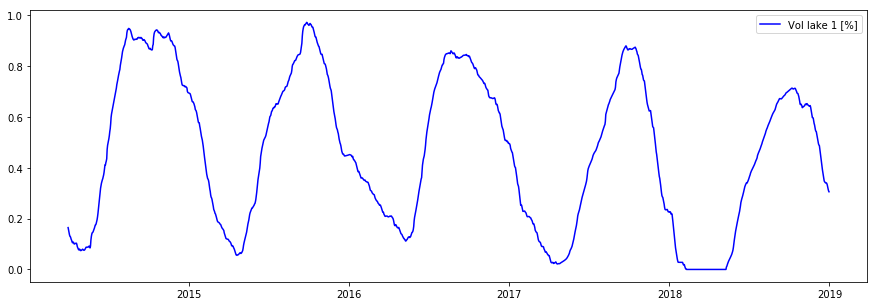

In [33]:
plt.plot('Vol lake 1 [%]', data=df, color='blue')
plt.legend()

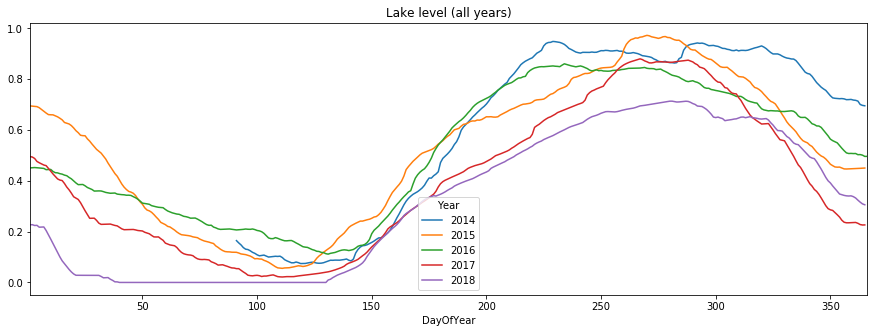

In [34]:
# all value plotted on one year
Lakelevel = pd.DataFrame(df.loc[:, ['Date','Vol lake 1 [%]']])
Lakelevel.index = Lakelevel['Date']

# Add the year and day of years features, then pivot to have one column of data per year (ronw = day of year)
Lakelevel["Year"] = Lakelevel.index.year
Lakelevel["DayOfYear"] = Lakelevel.index.dayofyear
 
YearLakelevel = Lakelevel.pivot(index='DayOfYear', columns='Year', values='Vol lake 1 [%]')

YearLakelevel.plot(title="Lake level (all years)")

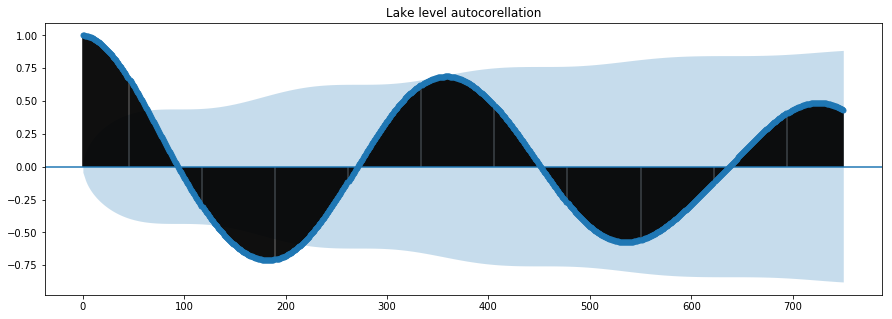

In [35]:
# plot correlogram
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Vol lake 1 [%]'], lags=750, title ="Lake level autocorellation")
pyplot.show()


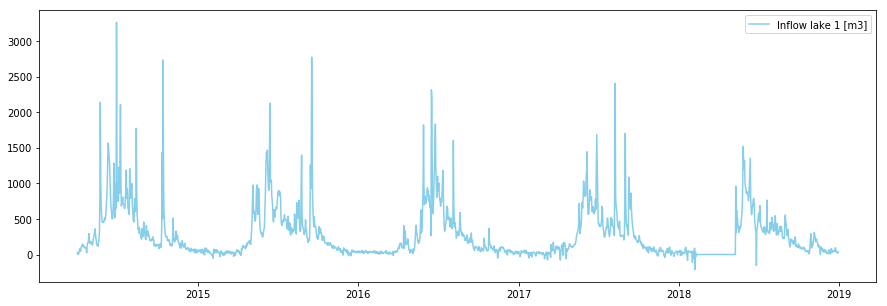

In [36]:
plt.plot('Inflow lake 1 [m3]', data=df, color='skyblue')
plt.legend()

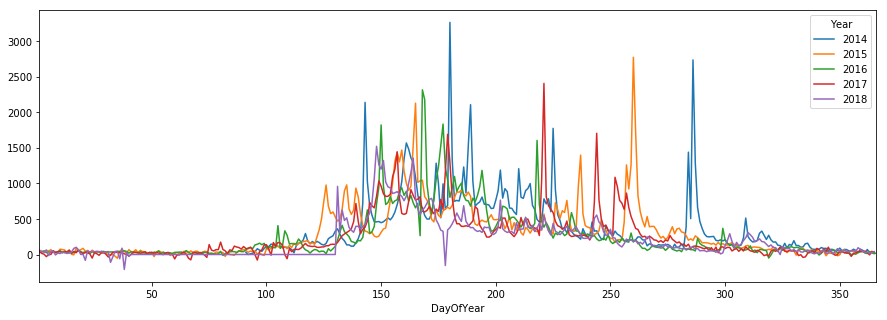

In [37]:
# all value plotted on one year
Inflows = pd.DataFrame(df.loc[:, ['Date','Inflow lake 1 [m3]']])
Inflows.index = Inflows['Date']

# Add the year and day of years features, then pivot to have one column of data per year (ronw = day of year)
Inflows["Year"] = Inflows.index.year
Inflows["DayOfYear"] = Inflows.index.dayofyear
 
YearInflows = Inflows.pivot(index='DayOfYear', columns='Year', values='Inflow lake 1 [m3]')

YearInflows.plot()

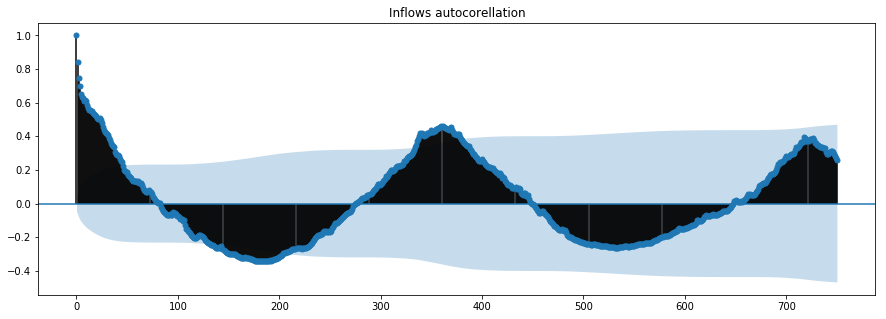

In [38]:
# plot correlogram
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Inflow lake 1 [m3]'], lags=750, title ="Inflows autocorellation")
pyplot.show()

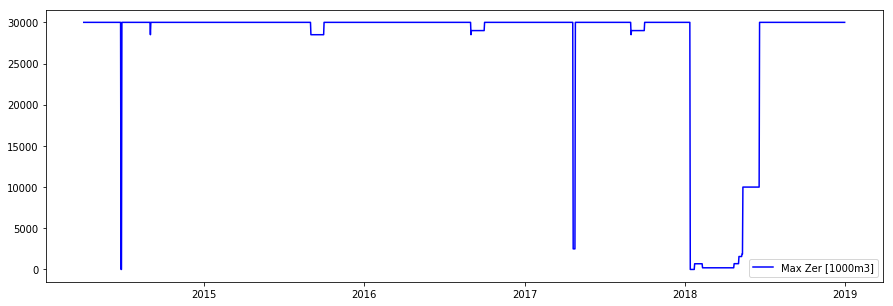

In [39]:
plt.plot('Max Zer [1000m3]', data=df, color='blue')
plt.legend()

### Identify inconsistent data: days when minimum production constraint is larger than maxium authorised


In [40]:
# Events when min production is lower than max allowed production, torance of 50 (84 events)
NRGThreshold = 50
MinGtMax= df[df['Min prod']-df['MaxVariants'] >NRGThreshold ][['Min prod','MaxVariants']]

MinGtMax

Min prod  MaxVariants
Date                             
2014-04-16   283.000         94.5
2014-05-17   330.000        132.0
2014-05-18   270.000        132.0
2014-06-04   510.000        291.0
2014-06-05   360.000        291.0
2014-06-07   450.000        366.3
2014-06-08   450.000        366.3
2014-06-09   487.000        366.3
2014-06-10   480.000        366.3
2014-06-12   600.000        522.0
2014-06-13   622.000        522.0
2014-06-14   600.000        432.0
2014-06-15   510.000        432.0
2014-06-17   570.000        375.6
2014-06-19   570.000        460.8
2014-06-20   600.000        460.8
2014-06-21   600.000        198.0
2014-06-22   300.000        198.0
2014-06-24   420.000        319.8
2014-06-25   540.000        319.8
2014-06-26   540.000        414.0
2014-06-28   630.000        240.0
2014-06-30   600.000        378.3
2014-07-03   570.000        480.0
2014-07-04   510.000        435.0
2014-07-05   480.000        345.0
2014-07-06   422.000        345.0
2014-07-08   314.000          0.0
2014-07-09   360.000          0.0
2014-07-11   480.000        315.0
...              ...          ...
2015-06-02   360.000        300.0
2015-06-03   390.000        300.0
2015-06-05   480.000        363.3
2015-06-06   510.000        363.3
2015-06-07   510.000        363.3
2015-06-09   750.000        680.4
2015-06-11   810.000        687.9
2015-06-13   720.000        465.0
2015-06-14   570.000        465.0
2015-06-15   368.000        276.0
2015-06-16   300.000          0.0
2015-06-20   450.000        345.0
2015-06-22   390.000        222.0
2015-06-24   570.000        358.8
2015-06-25   510.000        307.2
2015-06-27   540.000        240.0
2015-07-04   420.000        249.6
2015-07-09   420.000          0.0
2015-07-10   586.000        518.7
2015-07-11   434.000         58.8
2015-07-12   181.000         58.8
2015-07-25   300.000        199.2
2015-07-29   292.000        165.6
2016-05-04   150.000          0.0
2016-06-08   690.000        591.0
2016-06-20   870.000        745.2
2016-06-21   420.000          0.0
2016-11-21    90.000          0.0
2017-04-28   247.097        182.4
2018-06-19   210.000          0.0

[84 rows x 2 columns]

In [0]:
# define sub set for statistical analysis
# disguard data columns, and details of variants
df_analysis = df.filter(['Min prod', 'Inflow lake 1 [m3]', \
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
       'Vol lake 1 [1000m3]', 'Vol lake 1 [%]', 'Max Zer [1000m3]','Availability plant 1 [MW]', \
       'Availability plant 2 [MW]', 'Availability plant 3 [MW]', \
       'Availability plant 4 [MW]', 'Availability plant 1 [%]', \
       'Availability plant 2 [%]', 'Availability plant 3 [%]', \
       'Availability plant 4 [%]', 'EnergyVar1', 'EnergyVar2', 'EnergyVar3',\
       'EnergyVar4', 'MaxVariants','Variante Prio','NbVar', 'Weekend'], axis=1)

# force Weekend column to numeric value
df_analysis['Weekend'] = df_analysis['Weekend'] .astype(int)

In [0]:
# Move target features to last columns, i.e "Min prod", 'EnergyVar1', 'EnergyVar2', 'EnergyVar3','EnergyVar4', 'NbVar'


In [105]:
# display simple stasticss of data frame
display(round(df_analysis.describe(),2))

Min prod  Inflow lake 1 [m3]  ...    NbVar  Weekend
count   1736.00             1736.00  ...  1736.00  1736.00
mean     227.05              273.07  ...     1.76     0.29
std      200.06              353.16  ...     0.73     0.45
min        0.00             -210.00  ...     0.00     0.00
25%       90.00               41.00  ...     1.00     0.00
50%      150.00              130.50  ...     2.00     0.00
75%      300.00              381.25  ...     2.00     1.00
max     1470.00             3262.00  ...     4.00     1.00

[8 rows x 19 columns]

<Figure size 1584x1584 with 0 Axes>

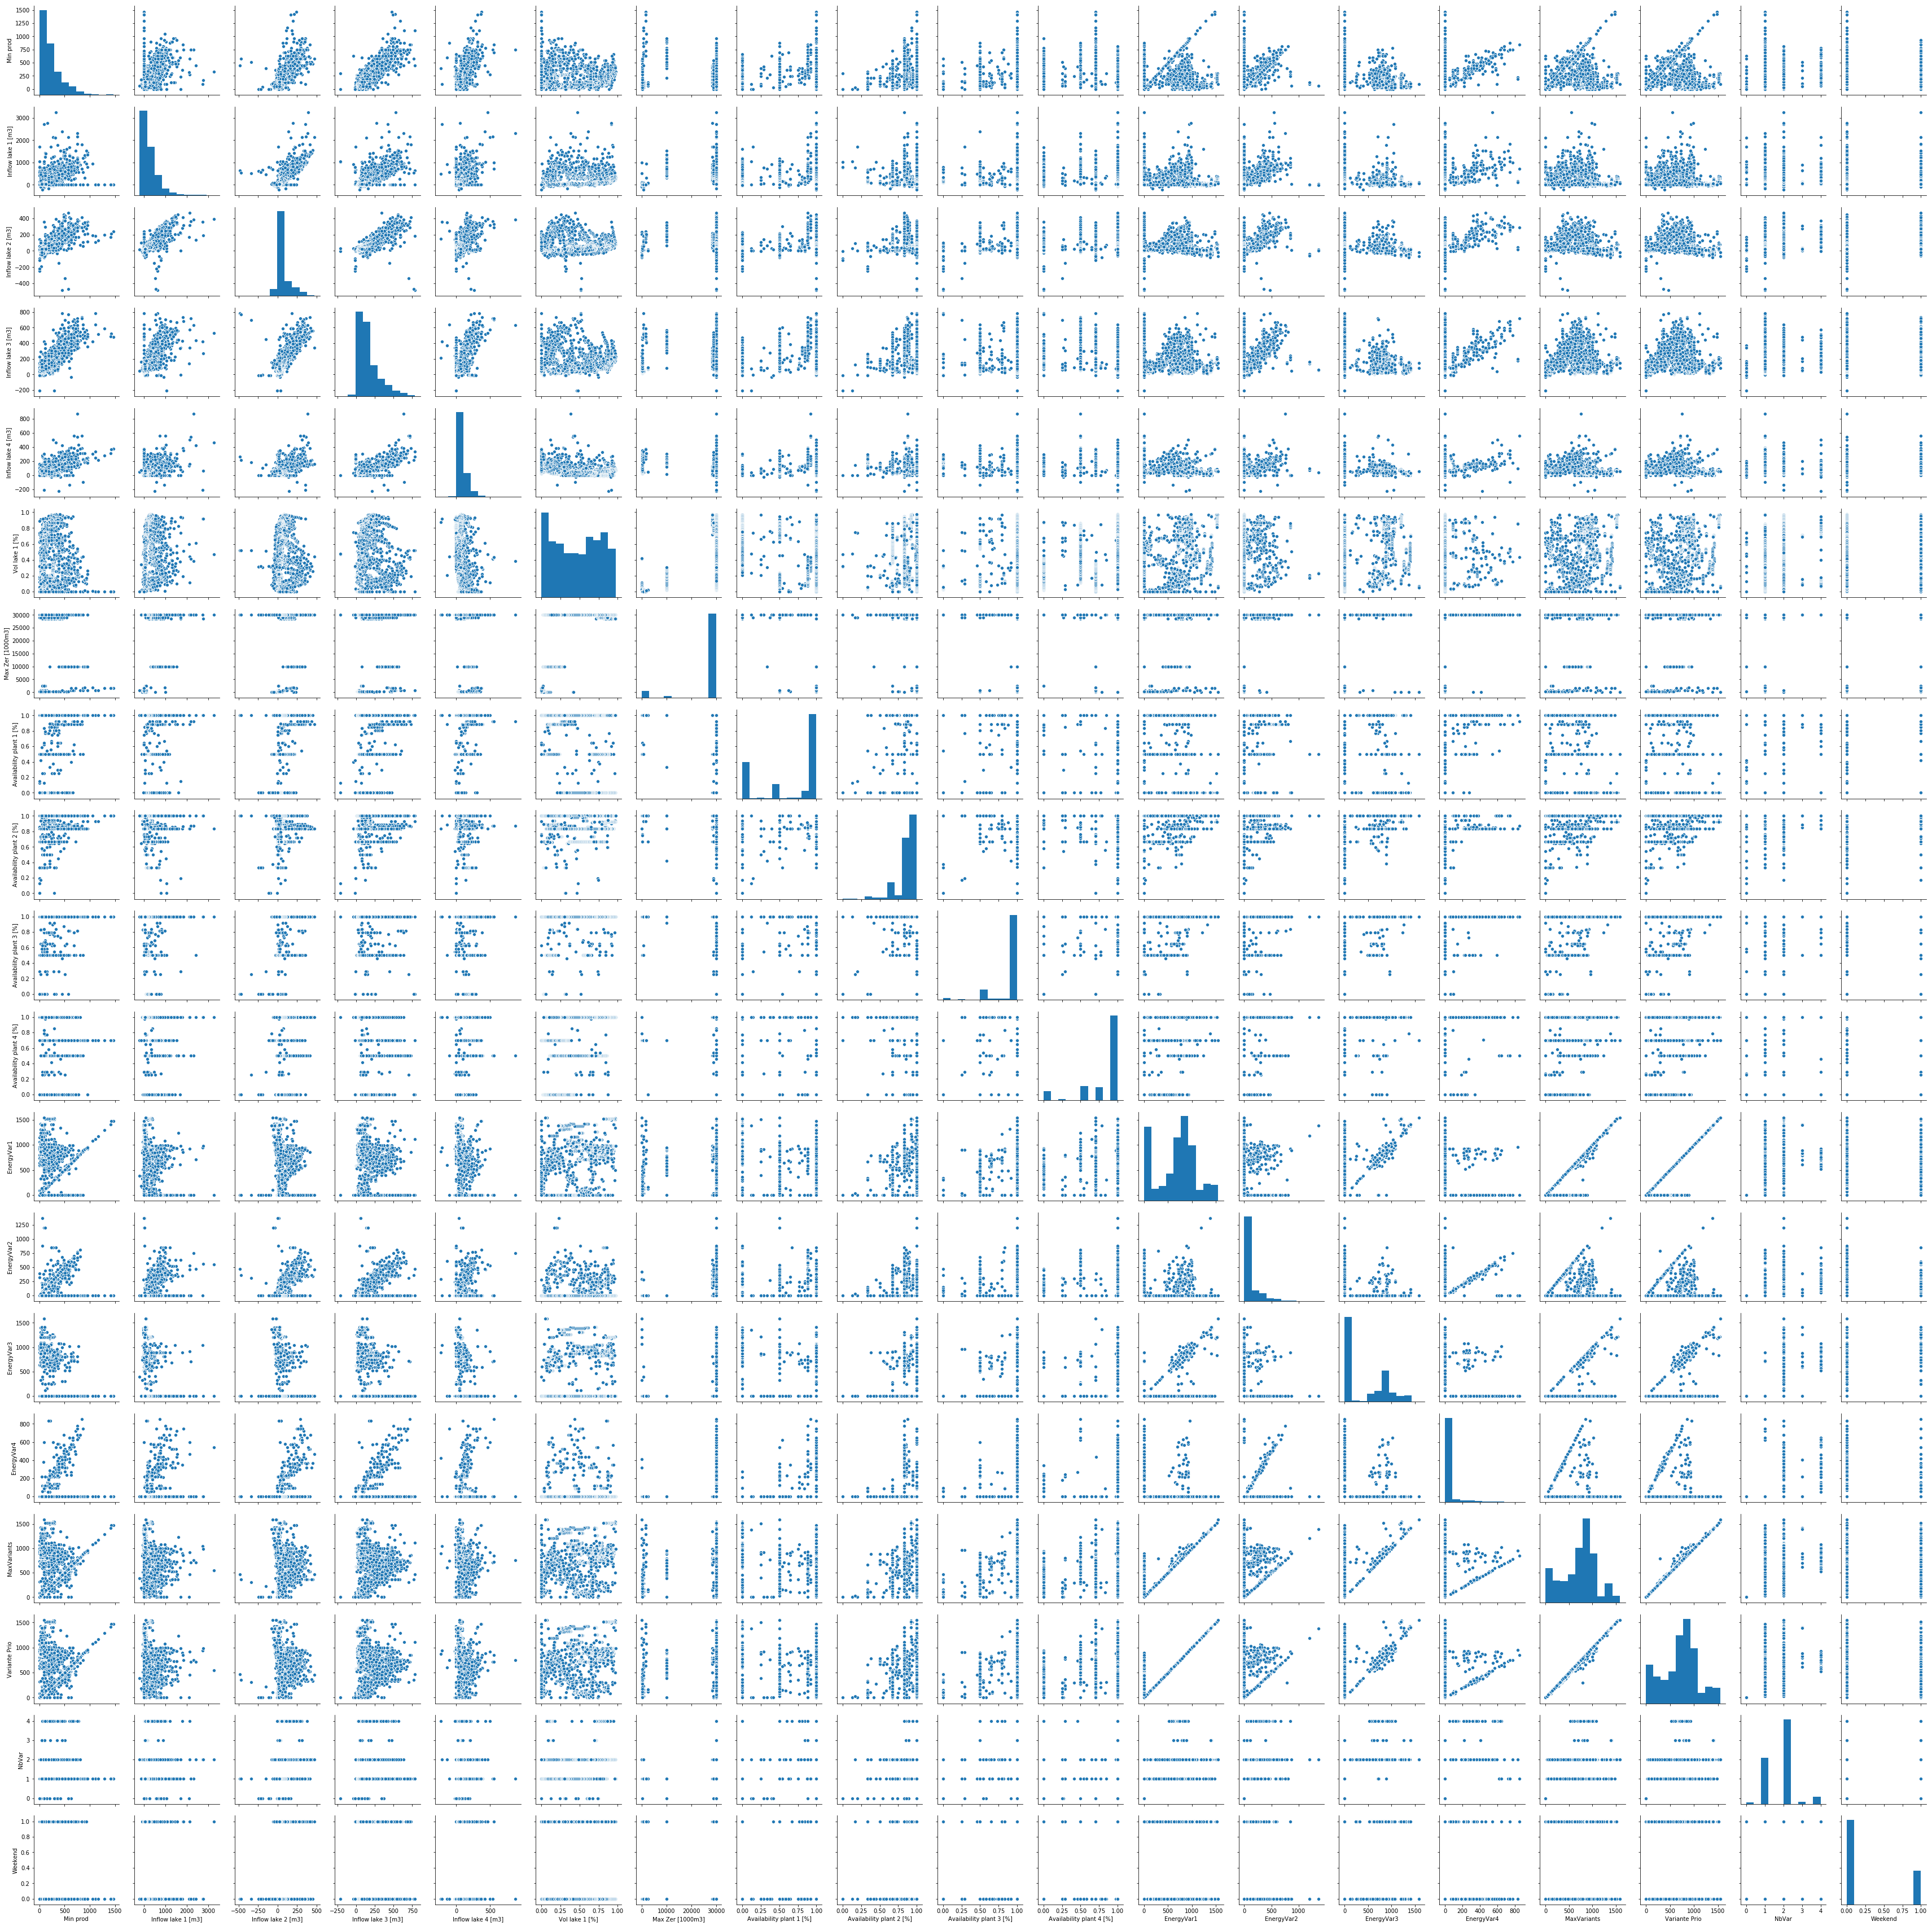

In [106]:
## %matplotlib inline
# Basic correlogram
plt.figure(figsize=(22, 22))
sns.pairplot(df_analysis)


Text(0.5, 1.0, 'Minimum Production')

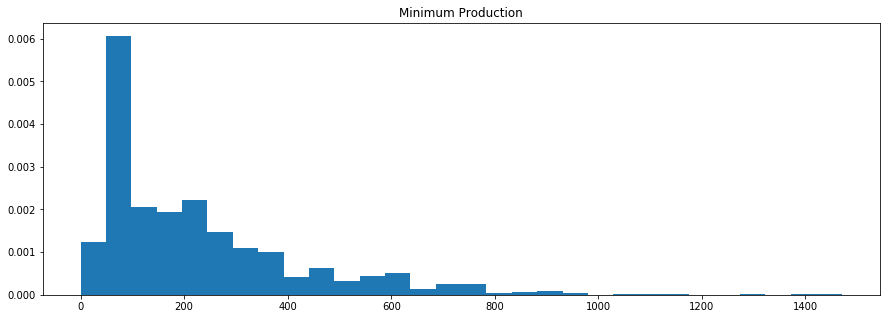

In [107]:
plt.hist(df["Min prod"], density=True, bins=30)
plt.title('Minimum Production')

Text(0.5, 1.0, 'Variante Prio')

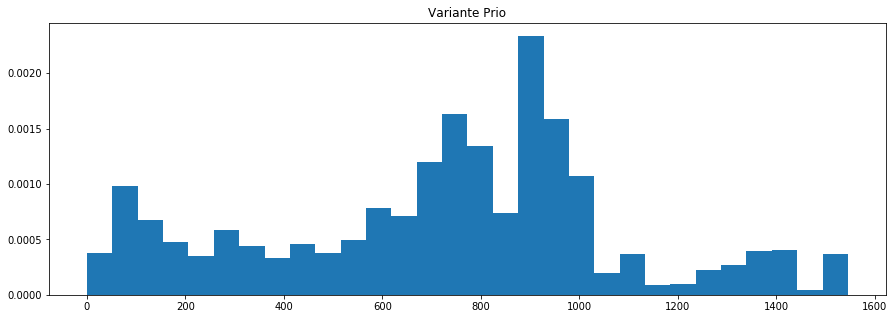

In [108]:
plt.hist(df['Variante Prio'], density=True, bins=30)
plt.title('Variante Prio')

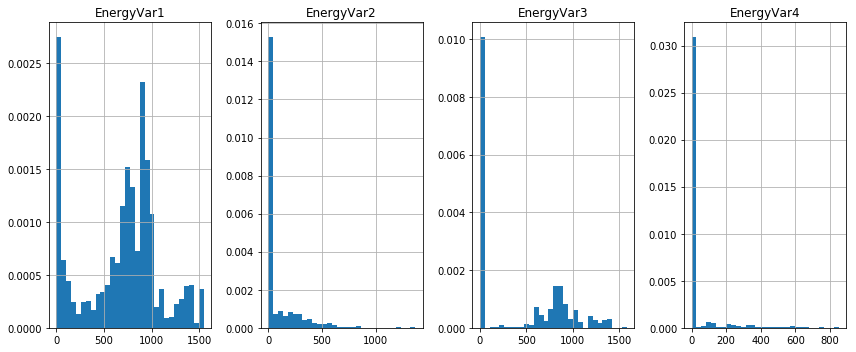

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5))  # 1 rows, 4 columns
for i in range(1,5):  
    df.hist(column ="EnergyVar"+str(i), density=True, bins=30, ax=ax[i-1])
    
plt.tight_layout()     

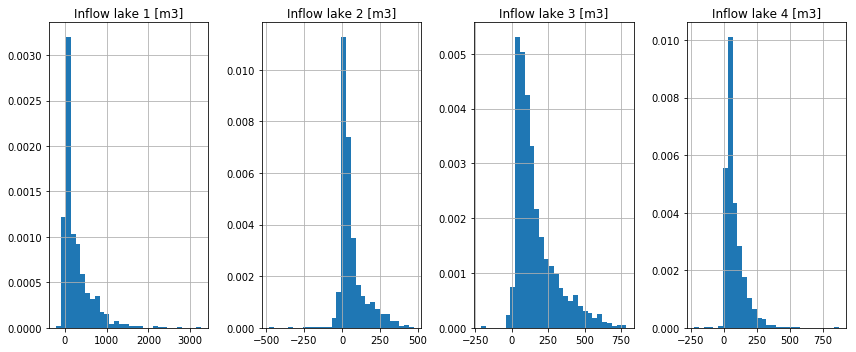

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5))  # 1 rows, 4 columns
for i in range(1,5):  
    df.hist(column ="Inflow lake "+str(i)+" [m3]", density=True, bins=30, ax=ax[i-1])
    
plt.tight_layout()     

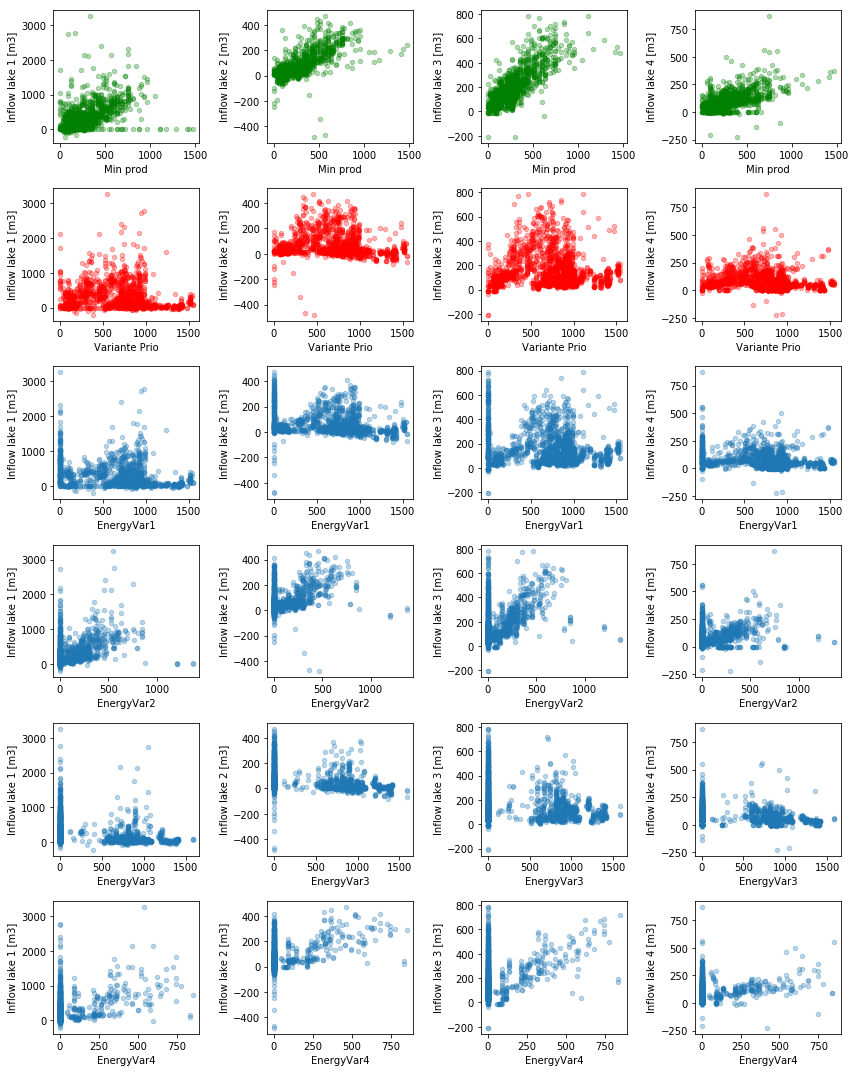

In [111]:
# display scatter plots of output features as a function of lake levels

fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,15))  # 2 rows, 4 columns
#loop over lakes (1 to 4)
for i in range(1,5):    
    # Plot min production in green color
    df.plot.scatter(x='Min prod', y='Inflow lake '+str(i)+' [m3]', ax=ax[0, i-1],  c='g', alpha=0.3)
    # Plot Variante Prio max production in red color
    df.plot.scatter(x='Variante Prio', y='Inflow lake '+str(i)+' [m3]', ax=ax[1, i-1],  c='r', alpha=0.3)
    #loop over variants (1 to 4)
    for j in range (1,5):
        df.plot.scatter(x='EnergyVar'+str(j),  y='Inflow lake '+str(i)+' [m3]', ax=ax[j+1, i-1], alpha=0.3)

plt.tight_layout() 



## Machine learning analysis and forecasting

### Train / test data set split

In [112]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1736 entries, 2014-04-01 to 2018-12-31
Data columns (total 19 columns):
Min prod                    1736 non-null float64
Inflow lake 1 [m3]          1736 non-null int64
Inflow lake 2 [m3]          1736 non-null float64
Inflow lake 3 [m3]          1736 non-null float64
Inflow lake 4 [m3]          1736 non-null float64
Vol lake 1 [%]              1736 non-null float64
Max Zer [1000m3]            1736 non-null int64
Availability plant 1 [%]    1736 non-null float64
Availability plant 2 [%]    1736 non-null float64
Availability plant 3 [%]    1736 non-null float64
Availability plant 4 [%]    1736 non-null float64
EnergyVar1                  1736 non-null float64
EnergyVar2                  1736 non-null float64
EnergyVar3                  1736 non-null float64
EnergyVar4                  1736 non-null float64
MaxVariants                 1736 non-null float64
Variante Prio               1736 non-null float64
NbVar                       1

In [113]:
res = np.where(df_analysis.columns== 'MaxVariants')
print(len(df_analysis.columns))
print(res[0])
print(df_analysis.columns)

19
[15]
Index(['Min prod', 'Inflow lake 1 [m3]', 'Inflow lake 2 [m3]',
       'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', 'Vol lake 1 [%]',
       'Max Zer [1000m3]', 'Availability plant 1 [%]',
       'Availability plant 2 [%]', 'Availability plant 3 [%]',
       'Availability plant 4 [%]', 'EnergyVar1', 'EnergyVar2', 'EnergyVar3',
       'EnergyVar4', 'MaxVariants', 'Variante Prio', 'NbVar', 'Weekend'],
      dtype='object')


In [114]:
# We split using a 90/10 ratio, but keeping the data in chronological order
# The dataframe to use is the df_analysis dataframe

CutPoint = round(len(df_analysis.index)*0.90)
print(CutPoint)

regressors = ['Inflow lake 1 [m3]', \
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
       'Vol lake 1 [%]','Max Zer [1000m3]','Availability plant 1 [%]', \
       'Availability plant 2 [%]', 'Availability plant 3 [%]', \
       'Availability plant 4 [%]', 'Weekend']
df_reg = df.filter(regressors, axis=1)

xTrain = df_reg.iloc[:CutPoint, :] 
xTest  = df_reg.iloc[CutPoint:, :]
yTrain = df_analysis.iloc[:CutPoint, 0]   # predict minimum production in a first step
yTest  = df_analysis.iloc[CutPoint:, 0]
print(len(yTrain))
print(len(yTest))

yTest.head()

1562
1562
174


Date
2018-07-11    270.0
2018-07-12    270.0
2018-07-13    240.0
2018-07-14     60.0
2018-07-15     60.0
Name: Min prod, dtype: float64

In [0]:
# Forecast using Random Forest (500 trees)
from sklearn.ensemble.forest import RandomForestRegressor
np.random.seed(42) # set seed for reproducibility
RF_Model = RandomForestRegressor(n_estimators=500)
 
# Fit the RF model with features and labels.
rgr=RF_Model.fit(xTrain, yTrain)

In [116]:
X_test_predict=pd.DataFrame(
    rgr.predict(xTest), columns=['ForecastRF'], index = xTest.index)
X_test_predict.head()

ForecastRF
Date                  
2018-07-11  254.038970
2018-07-12  242.844582
2018-07-13  242.434582
2018-07-14  267.040000
2018-07-15  258.886000

In [117]:
X_test_predict
resid = X_test_predict
resid["yTest"] = yTest
resid["Mean(yTrain)"] = yTrain.mean()
resid.head()

ForecastRF  yTest  Mean(yTrain)
Date                                       
2018-07-11  254.038970  270.0    239.406155
2018-07-12  242.844582  270.0    239.406155
2018-07-13  242.434582  240.0    239.406155
2018-07-14  267.040000   60.0    239.406155
2018-07-15  258.886000   60.0    239.406155

In [0]:
#plt.plot(x=resid['Res'], y=resid['yTest'])
#resid['Res']
#resid['Delta'] = resid['yTest']-resid['ForecastRF']

In [119]:
resid.head(5)

ForecastRF  yTest  Mean(yTrain)
Date                                       
2018-07-11  254.038970  270.0    239.406155
2018-07-12  242.844582  270.0    239.406155
2018-07-13  242.434582  240.0    239.406155
2018-07-14  267.040000   60.0    239.406155
2018-07-15  258.886000   60.0    239.406155

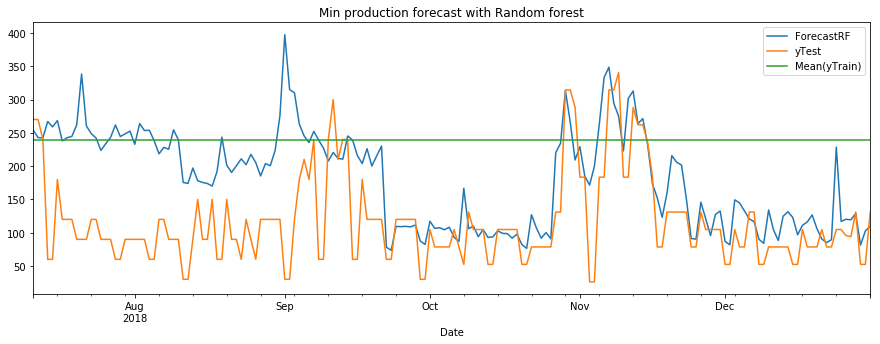

In [120]:
resid.plot(title = 'Min production forecast with Random forest')

In [122]:
# Extract default Random Forest metrics, i.e R^2 and OOB score
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(RF_Model.score(xTrain, yTrain), 
                                                                                             RF_Model.oob_score,
                                                                                             RF_Model.score(xTest, yTest)))


R^2 Training Score: 0.98 
OOB Score: 0.00 
R^2 Validation Score: -1.14


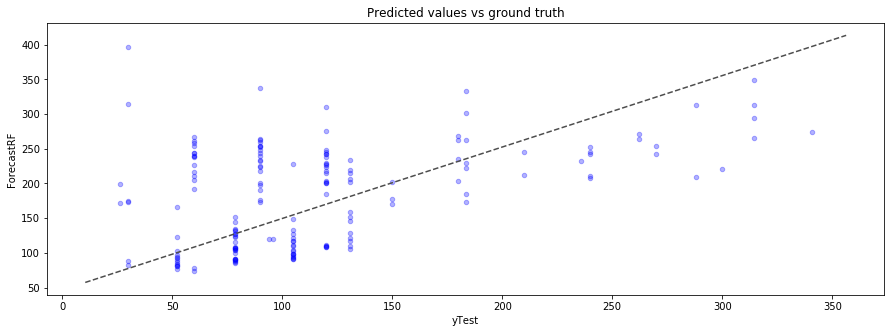

In [132]:
#plot residuals vs actual values
ax = resid.plot.scatter(x='yTest', y='ForecastRF',  c='b', alpha=0.3, title = "Predicted values vs ground truth")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

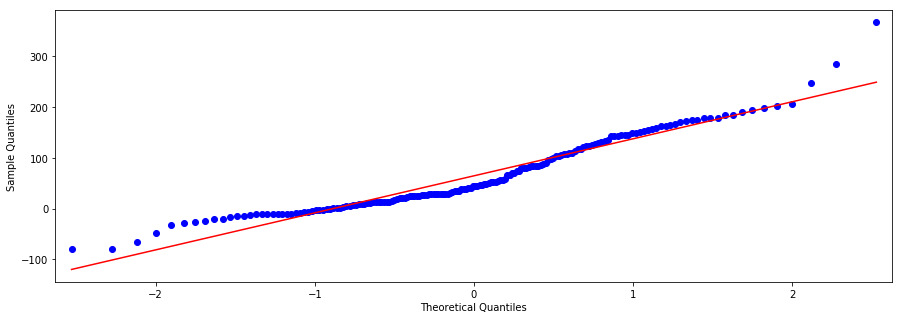

In [130]:
# Plot qqplot of residuals
from statsmodels.graphics.gofplots import qqplot
resid['residuals'] = resid['ForecastRF']	- resid['yTest']
qqplot(resid['residuals'], line = "s")
pyplot.show()

Mean absolute scaled error

\begin{equation*}  MASE=\frac{MAE}{MAE_{in-sample, \, naive}} \end{equation*}
where $MAE$ is the mean absolute error produced by the actual forecast; 
while  $MAE_{in-sample, \, naive} $ is the mean absolute error produced by a naive forecast



In [250]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( rgr.predict(xTest), yTest))
print("RMSE = %5.2f" % (trainScore))

# calculate root mean squared error
MAE = mean_absolute_error(rgr.predict(xTest), yTest)
print("MAE  = %5.2f" % (MAE))

# to be checked against mean ! (or linear regression)
resMean = mean_absolute_error(resid["Mean(yTrain)"], yTest)
print("MAE Mean = %5.2f" %(resMean))
print("MASE = %5.2f" %(MAE/resMean))

RMSE = 97.45
MAE  = 71.62
MAE Mean = 130.95
MASE =  0.55


### Features importance as delivered by Random Forest algorithm
Let's visualize the feature importance values from the random forest including a measure of the mean impurity decrease variability (here: standard deviation)



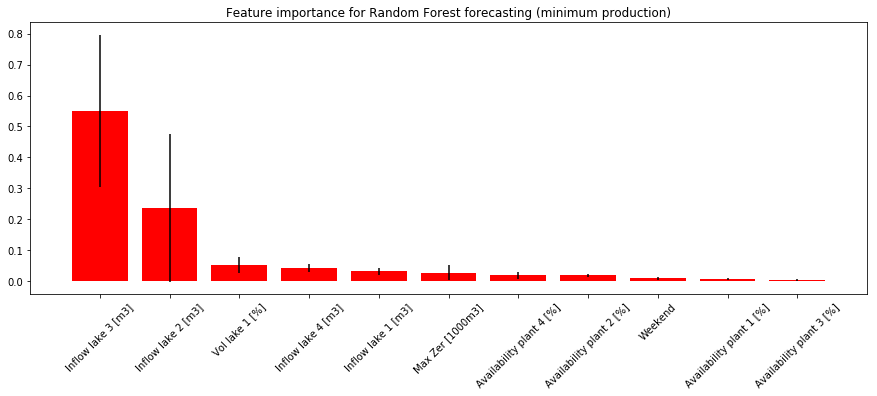

In [251]:
importances = RF_Model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_Model.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [xTrain.columns[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance for Random Forest forecasting (minimum production)")
plt.bar(range(xTrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(xTrain.shape[1]), names, rotation = 45)
plt.xlim([-1, xTrain.shape[1]])
plt.show()

In [252]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(RF_Model, xTest)
for i in range(len(xTest)):
    print ("Instance", i)
    print ("Bias (trainset mean)", bias[i])
    print ("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 names), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print ("-"*20) 
    

Instance 0
Bias (trainset mean) 239.4773174699106
Feature contributions:
Vol lake 1 [%] -80.27
Availability plant 2 [%] 34.06
Inflow lake 1 [m3] 30.98
Inflow lake 2 [m3] 9.17
Inflow lake 4 [m3] 9.09
Availability plant 4 [%] 4.82
Inflow lake 3 [m3] 2.51
Max Zer [1000m3] 1.96
Availability plant 3 [%] 1.37
Weekend 1.02
Availability plant 1 [%] -0.15
--------------------
Instance 1
Bias (trainset mean) 239.4773174699106
Feature contributions:
Vol lake 1 [%] -84.04
Availability plant 2 [%] 37.12
Inflow lake 1 [m3] 29.97
Inflow lake 4 [m3] 6.97
Availability plant 4 [%] 4.97
Inflow lake 3 [m3] 3.24
Inflow lake 2 [m3] 1.73
Max Zer [1000m3] 1.42
Availability plant 3 [%] 1.07
Weekend 1.03
Availability plant 1 [%] -0.1
--------------------
Instance 2
Bias (trainset mean) 239.4773174699106
Feature contributions:
Vol lake 1 [%] -81.44
Availability plant 2 [%] 35.47
Inflow lake 1 [m3] 30.74
Inflow lake 4 [m3] 7.47
Availability plant 4 [%] 4.95
Max Zer [1000m3] 1.57
Inflow lake 2 [m3] 1.49
Availabili

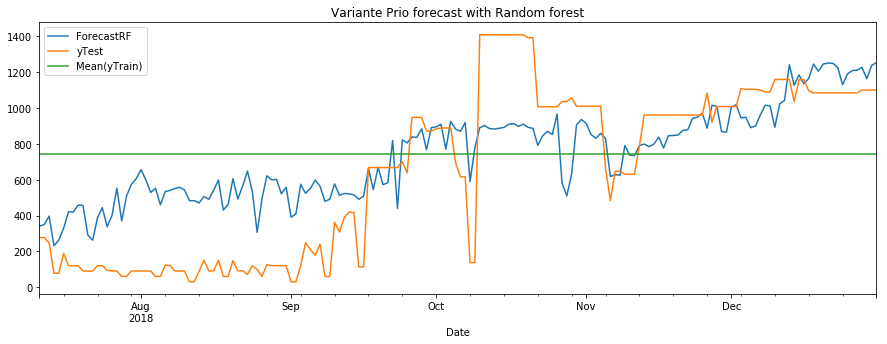

In [134]:
yTrain = df_analysis.iloc[:CutPoint, 15]   # predict Energy Variant 1
yTest  = df_analysis.iloc[CutPoint:, 15]

# Forecast using Random Forest (500 trees)
from sklearn.ensemble.forest import RandomForestRegressor
np.random.seed(42) # set seed for reproducibility
RF_Model = RandomForestRegressor(n_estimators=500)
 
# Fit the RF model with features and labels.
rgr=RF_Model.fit(xTrain, yTrain)

X_test_predict=pd.DataFrame(
    rgr.predict(xTest), columns=['ForecastRF'], index = xTest.index)

resid = X_test_predict
resid["yTest"] = yTest
resid["Mean(yTrain)"] = yTrain.mean()
resid.head()

resid.plot(title = 'Variante Prio forecast with Random forest')

In [137]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( rgr.predict(xTest), yTest))
print("RMSE = %5.2f" % (trainScore))

# calculate root mean squared error
MAE = mean_absolute_error(rgr.predict(xTest), yTest)
print("MAE  = %5.2f" % (MAE))

# to be checked against mean ! (or linear regression)
resMean = mean_absolute_error(resid["Mean(yTrain)"], yTest)
print("MAE Mean = %5.2f" %(resMean))
print("MASE = %5.2f" %(MAE/resMean))

RMSE = 300.43
MAE  = 247.32
MAE Mean = 420.57
MASE =  0.59


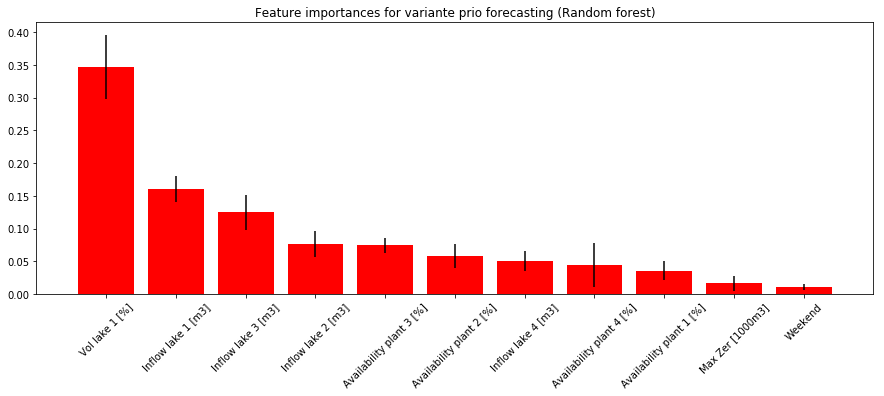

In [138]:
# Random forest regression for Variante Max Production

importances = RF_Model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_Model.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [xTrain.columns[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for variante prio forecasting (Random forest)")
plt.bar(range(xTrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(xTrain.shape[1]), names, rotation = 45)
plt.xlim([-1, xTrain.shape[1]])
plt.show()


### Artificial Neural Network regression for Minimum production


In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 

#Scale the data
stScaler = StandardScaler()  
stScaler.fit(xTrain)  
xTrain2 = stScaler.transform(xTrain)  
xTest2 = stScaler.transform(xTest) 

#Construct a multi-layer perceptron 
mlp = MLPRegressor(hidden_layer_sizes = [5,5,3],
                   alpha=0.00001,
                   activation = 'relu',
                   learning_rate_init = 0.001,
                   max_iter = 50000)
mlp.fit(xTrain2,yTrain)
ypred = mlp.predict(xTest2)

In [0]:
X_test_predict=pd.DataFrame(
    ypred, columns=['ForecastANN'], index = xTest.index)
resid = X_test_predict
resid["yTest"] = yTest
resid["Mean(yTrain)"] = yTrain.mean()
#resid['Delta'] = resid['yTest']-resid['ForecastANN']
resid.head(5)

ForecastANN  yTest  Mean(yTrain)
Date                                        
2018-07-11   209.649299  270.0    239.406155
2018-07-12   204.986190  270.0    239.406155
2018-07-13   207.699311  240.0    239.406155
2018-07-14   197.200793   60.0    239.406155
2018-07-15   210.362782   60.0    239.406155

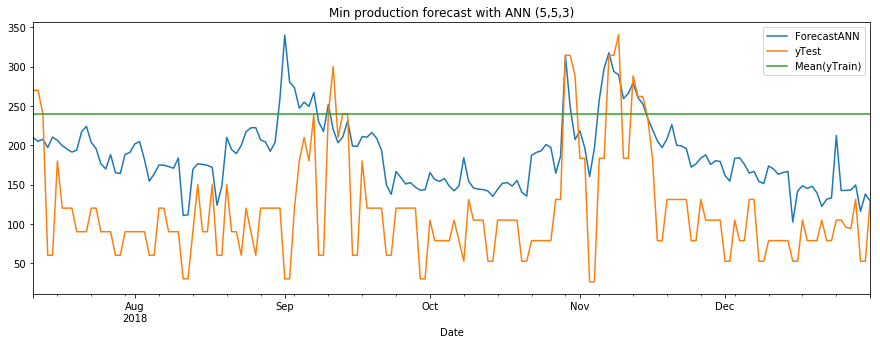

In [0]:
resid.plot(title = 'Min production forecast with ANN (5,5,3)')

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( ypred, yTest))
print("RMSE = %5.2f" % (trainScore))

# calculate root mean squared error
MAE = mean_absolute_error(ypred, yTest)
print("MAE  = %5.2f" % (MAE))

# to be checked against mean ! 
resMean = mean_absolute_error(resid["Mean(yTrain)"], yTest)
#print("Res Mean = %5.2f" %(resMean))
print("MASE = %5.2f" %(MAE/resMean))


RMSE = 88.76
MAE  = 77.65
MASE =  0.59


In [212]:
# Forecasting Energy Variant 1
# We split using a 85/15 ratio, but keeping the data in chronological order
# The dataframe to use is the df_analysis dataframe

CutPoint = round(len(df_analysis.index)*0.90)
print(CutPoint)

regressors = ['Inflow lake 1 [m3]', \
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
       'Vol lake 1 [%]','Availability plant 1 [%]', \
       'Availability plant 2 [%]', 'Availability plant 3 [%]', \
       'Availability plant 4 [%]', 'Weekend']
df_reg = df.filter(regressors, axis=1)

xTrain = df_reg.iloc[:CutPoint, :] 
xTest  = df_reg.iloc[CutPoint:, :]
yTrain = df_analysis.iloc[:CutPoint, 15]   # predict Energy Variant 1
yTest  = df_analysis.iloc[CutPoint:, 15]
print(len(yTrain))
print(len(yTest))

yTest.head()


1562
1562
174


Date
2018-07-11    277.2
2018-07-12    277.2
2018-07-13    247.2
2018-07-14     78.0
2018-07-15     78.0
Name: MaxVariants, dtype: float64

In [0]:
#Scale the data
stScaler = StandardScaler()  
stScaler.fit(xTrain)  
xTrain2 = stScaler.transform(xTrain)  
xTest2 = stScaler.transform(xTest) 

#Construct a multi-layer perceptron 
mlpEn = MLPRegressor(hidden_layer_sizes = [8,3],
                   alpha=0.00001,
                   activation = 'relu',
                   learning_rate_init = 0.001,
                   max_iter = 50000)
mlpEn.fit(xTrain2,yTrain)
ypredEn = mlpEn.predict(xTest2)

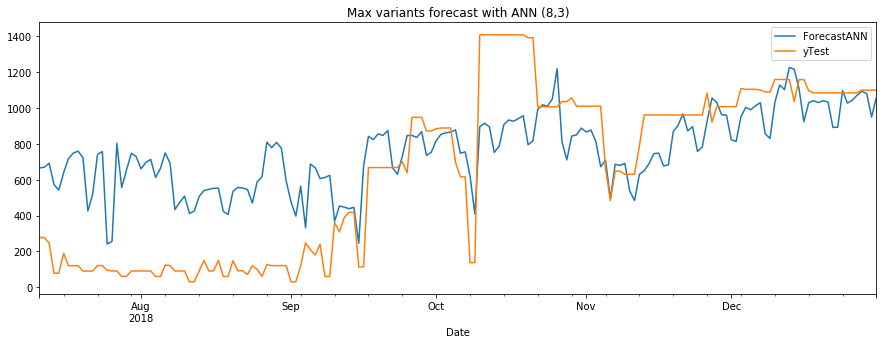

In [0]:
X_test_predict=pd.DataFrame(
    ypredEn, columns=['ForecastANN'], index = xTest.index)
residEn = X_test_predict
residEn["yTest"] = yTest
#resid['Delta'] = resid['yTest']-resid['ForecastANN']
residEn.plot(title = 'Max variants forecast with ANN (8,3)')

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( ypredEn, yTest))
print("RMSE = %5.2f" % (trainScore))

# calculate mean absolute error
MAE = mean_absolute_error(ypredEn, yTest)
print("MAE  = %5.2f" % (MAE))

# to be checked against mean ! or linear regression
print("Mean = %5.2f" %(yTrain.mean()))
print("Relative error = %5.2f" %(MAE/yTrain.mean()))



RMSE = 351.19
MAE  = 278.90
Mean = 741.92
Relative error =  0.38


In [0]:
# questions:
#- Why do we have negative inflows with huge values?
# inconsistent power/hours pairs: 13/11/2017, variante 3, value 8
# extend calendar with official days off?


In [0]:
# Ssupport Vector Regression
#Scale the data
stScaler = StandardScaler()  
stScaler.fit(xTrain)  
xTrain2 = stScaler.transform(xTrain)  
xTest2 = stScaler.transform(xTest) 

from sklearn.svm import SVR
regressor=SVR(kernel='linear')
regressor.fit(xTrain2,yTrain)
pred=regressor.predict(xTest2)
print(regressor.score(xTest2,yTest))

0.10403240428145077


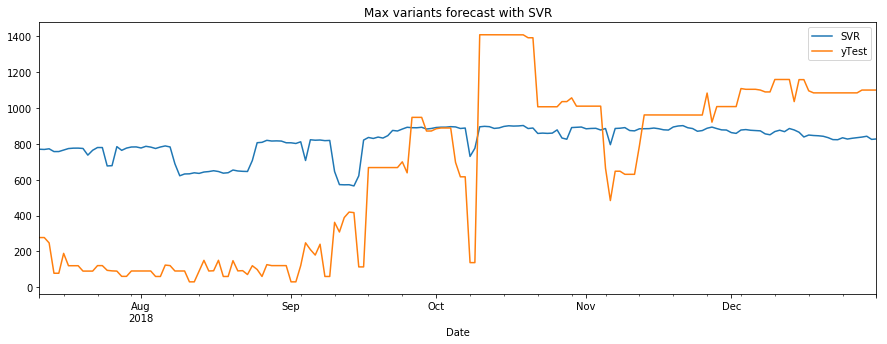

In [0]:
X_test_predict=pd.DataFrame(
    pred, columns=['SVR'], index = xTest.index)
residEn = X_test_predict
residEn["yTest"] = yTest
#resid['Delta'] = resid['yTest']-resid['ForecastANN']
residEn.plot(title = 'Max variants forecast with SVR')

In [0]:
# Keras implementation
import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

# define base model
model = Sequential()
model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model.fit(xTrain2,yTrain, validation_data=(xTest2,yTest),
	epochs=200, batch_size=8)


Using TensorFlow backend.
W0626 20:11:38.281457 140554964891520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 20:11:38.335598 140554964891520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 20:11:38.347233 140554964891520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0626 20:11:38.374261 140554964891520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 20:11:38.412991 14055

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Train on 1562 samples, validate on 174 samples
Epoch 1/200
1562/1562 [==============================] - 1s 611us/step - loss: 671593.6969 - mean_squared_error: 671593.6969 - mean_absolute_error: 741.3993 - val_loss: 633184.4791 - val_mean_squared_error: 633184.4791 - val_mean_absolute_error: 648.3867
Epoch 2/200
1562/1562 [==============================] - 0s 154us/step - loss: 664051.9965 - mean_squared_

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


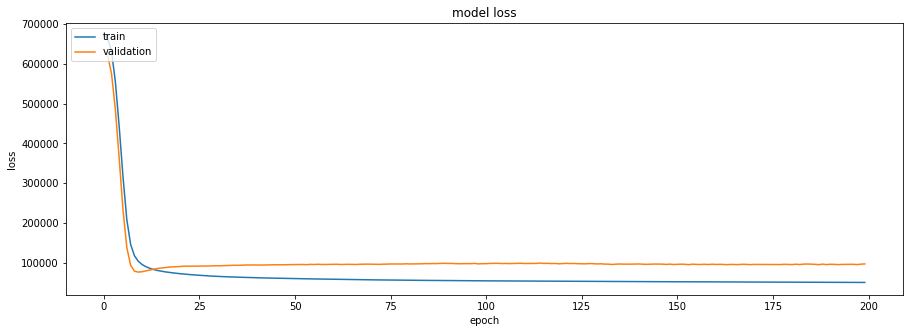

In [0]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

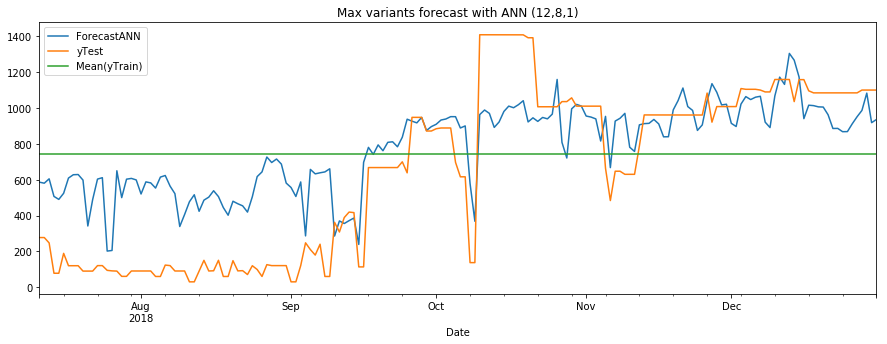

In [0]:
ynew= model.predict(xTest2)
X_test_predict=pd.DataFrame(
    ynew, columns=['ForecastANN'], index = xTest.index)
residEn = X_test_predict
residEn["yTest"] = yTest
residEn["Mean(yTrain)"] = yTrain.mean()
#resid['Delta'] = resid['yTest']-resid['ForecastANN']
residEn.plot(title = 'Max variants forecast with ANN (12,8,1)')


In [173]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( ynew, yTest))
print("RMSE = %5.2f" % (trainScore))

# calculate mean absolute error
MAE = mean_absolute_error(ynew, yTest)
print("MAE  = %5.2f" % (MAE))

# to be checked against mean ! or linear regression
print("Mean = %5.2f" %(yTrain.mean()))
MeanMAE = mean_absolute_error(residEn["Mean(yTrain)"], yTest)
print("Mean MAE = %5.2f" %(MeanMAE))
print("Relative error = %5.2f" %(MAE/MeanMAE))

NameError: ignored

In [0]:
# LSTM forecast


In [0]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()